In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os

# read in csv file
df = pd.read_csv('AG_NO3_fill_cells_remove_NAN.csv', header=[0])
#print(df.head)
df = df.dropna()
#print(df.head)
# Create a new column in the dataframe to store the labels as either 'Normal' or 'Anomaly'
df['label'] = 0
#print(df.head)

anomaliesGT = 77
step_size = 1

In [2]:
def detect_anomalies(df, window, percentileUpper, percentileLower):
    percentilesUpper = np.percentile(window['NO3N'], percentileUpper)
    percentilesLower = np.percentile(window['NO3N'], percentileLower)
    anomalies = (window['NO3N'] > percentilesUpper) | (window['NO3N'] < percentilesLower)
    df.loc[window.index[anomalies], 'label'] = 1
    return df

def slidingWindow(df, window_size, step_size, percentileUpper, percentileLower):
    df_sW = df.copy()
    for i in range(0, len(df) - window_size + 1, step_size):
        window = df_sW.iloc[i:i + window_size].copy()
        df_sW = detect_anomalies(df_sW, window, percentileUpper, percentileLower)
    return df_sW

def evaluation(df, window_size, step_size, anomaliesGT, percentileUpper, percentileLower):    
    df_eval = df.copy()
    df_anomaly = slidingWindow(df_eval, window_size, step_size, percentileUpper, percentileLower)
    
    label_counts = df_anomaly['label'].value_counts()
    count_0 = label_counts.get(0, 0)
    count_1 = label_counts.get(1, 0)
    
    return df_anomaly, count_0, count_1

def performance(df, anomaliesGT):
    df_anomaly1 = df.copy()
    
    TP = df_anomaly1[(df_anomaly1['label'] == 1) & (df_anomaly1['Student_Flag'] == 1)].shape[0]
    FP = df_anomaly1[(df_anomaly1['label'] == 1) & (df_anomaly1['Student_Flag'] == 0)].shape[0]
    TN = df_anomaly1[(df_anomaly1['label'] == 0) & (df_anomaly1['Student_Flag'] == 0)].shape[0]
    FN = df_anomaly1[(df_anomaly1['label'] == 0) & (df_anomaly1['Student_Flag'] == 1)].shape[0]
    
    try:
        precision = TP / (TP + FP)
    except ZeroDivisionError:
        print("Error: Division by zero!")
    else:
        precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    accuracy_anomaly_detection = TP / anomaliesGT
    accuracy_normal_detection = TN / (len(df_anomaly1) - anomaliesGT)
    
    return count_0, count_1, TP, accuracy_anomaly_detection, accuracy_normal_detection

def performanceFull(df, anomaliesGT):
    df_anomaly1 = df.copy()
    
    TP = df_anomaly1[(df_anomaly1['label'] == 1) & (df_anomaly1['Student_Flag'] == 1)].shape[0]
    FP = df_anomaly1[(df_anomaly1['label'] == 1) & (df_anomaly1['Student_Flag'] == 0)].shape[0]
    TN = df_anomaly1[(df_anomaly1['label'] == 0) & (df_anomaly1['Student_Flag'] == 0)].shape[0]
    FN = df_anomaly1[(df_anomaly1['label'] == 0) & (df_anomaly1['Student_Flag'] == 1)].shape[0]
    
    try:
        precision = TP / (TP + FP)
    except ZeroDivisionError:
        print("Error: Division by zero!")
    else:
        precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    accuracy_anomaly_detection = TP / anomaliesGT
    accuracy_normal_detection = TN / (len(df_anomaly1) - anomaliesGT)
    
    return print(f'Normal flags: {count_0}\nAnomaly flags: {count_1}\nTrue Positives: {TP}\nTrue Negatives: {TN}\nFalse Positives: {FP}\nFalse Negatives: {FN}\nPrecision: {precision}\nRecall: {recall}\nAccuracy as (TP + TN) / (TP + TN + FP + FN): {accuracy}\naccuracy_anomaly_detection as TP / anomaliesGT: {accuracy_anomaly_detection}\naccuracy_normal_detection as TN / (len(df_anomaly1) - anomaliesGT): {accuracy_normal_detection}')

In [3]:
results = pd.DataFrame(columns=['percentileUpper', 'window_size', 'count_0', 'count_1', 'TP', 'accuracy_anomaly_detection', 'accuracy_normal_detection'])
window_size_range = range(50, 111, 5)
percentileUpper_list = [95, 99.7]                                

start_time = time.time()  # Record start time
for window_size in window_size_range:
    for percentileUpper in percentileUpper_list:
        df1 = df.copy()
        percentileLower = 100 - percentileUpper
        df_anomaly, count_0, count_1 = evaluation(df1, window_size, step_size, anomaliesGT, percentileUpper, percentileLower)
    
        anomalies = df_anomaly[df_anomaly['label'] == '1']
        
        #if you want a graph for each condition tested
        '''plt.scatter(df_anomaly.index, df_anomaly['NO3N'], color='blue', label='NO3N Data')
        plt.scatter(df_anomaly[df_anomaly['label'] == 1].index, df_anomaly[df_anomaly['label'] == 1]['NO3N'], color='red', label='Detected anomalous datapoints')
        plt.scatter(df_anomaly[df_anomaly['Student_Flag'] == 1].index, df_anomaly[df_anomaly['Student_Flag'] == 1]['NO3N'], color='green', label='Ground truth anomalous datapoints')
        plt.xlabel('Data point')
        plt.ylabel('Nitrate')
        plt.title(f'Anomaly Detection. Window size= {window_size}, percentile= {percentileUpper}')
        plt.legend(loc='upper left')
        plt.show()'''
        
        count_0, count_1, TP, accuracy_anomaly_detection, accuracy_normal_detection = performance(df_anomaly, anomaliesGT)
        
        new_row = {'percentileUpper': percentileUpper, 'window_size': window_size, 'count_0': count_0, 'count_1': count_1, 'TP': TP, 'accuracy_anomaly_detection': accuracy_anomaly_detection, 'accuracy_normal_detection': accuracy_normal_detection}
        results = pd.concat([results, pd.DataFrame([new_row])], ignore_index=True)

end_time = time.time()  # Record end time
execution_time = end_time - start_time  # Calculate execution time
minutes, seconds = divmod(execution_time, 60)
print(f'Time to compute: {minutes} minutes {seconds} seconds')
print(results)

Time to compute: 3.0 minutes 5.4212963581085205 seconds
   percentileUpper window_size count_0 count_1  TP  \
0               95          50   11264    4544  76   
1             99.7          50   13791    2017  64   
2               95          55   11494    4314  75   
3             99.7          55   13886    1922  64   
4               95          60   11685    4123  75   
5             99.7          60   13990    1818  64   
6               95          65   10976    4832  75   
7             99.7          65   14080    1728  63   
8               95          70   11147    4661  75   
9             99.7          70   14135    1673  63   
10              95          75   11308    4500  75   
11            99.7          75   14215    1593  62   
12              95          80   11455    4353  75   
13            99.7          80   14277    1531  62   
14              95          85   10883    4925  75   
15            99.7          85   14325    1483  60   
16              95        

In [4]:
condition1 = results['accuracy_anomaly_detection'] > 0.80
condition2 = results['accuracy_normal_detection'] > 0.80
#print(condition1)
#count_c1 = condition1.sum()
#print(count_c1)
#print(condition2)
#count_c2 = condition2.sum()
#print(count_c2)

# Get the index positions where both conditions are satisfied
indices_satisfying_condition1 = condition1.index[condition1].tolist()
indices_satisfying_condition2 = condition2.index[condition2].tolist()
indices_satisfying_both_conditions = condition1.index[condition1 & condition2].tolist()
#print(indices_satisfying_condition1)
#print(indices_satisfying_condition2)
#print(indices_satisfying_both_conditions)

# Create df containing the data from indices that meet both conditions
passing_conditions =  results.loc[indices_satisfying_both_conditions, :]
#print(passing_conditions)

# One way of determining the best performance is summing the metrics. Here, what has both best anomaly detection and normal detection: anomaly detection + normal detection
passing_conditions['accuracySum'] = passing_conditions['accuracy_anomaly_detection'] + passing_conditions['accuracy_normal_detection']
print(passing_conditions)

maxPerformance = passing_conditions['accuracySum'].idxmax()
print(maxPerformance)
print(results.loc[maxPerformance])

   percentileUpper window_size count_0 count_1  TP  \
1             99.7          50   13791    2017  64   
3             99.7          55   13886    1922  64   
5             99.7          60   13990    1818  64   
7             99.7          65   14080    1728  63   
9             99.7          70   14135    1673  63   
11            99.7          75   14215    1593  62   
13            99.7          80   14277    1531  62   

    accuracy_anomaly_detection  accuracy_normal_detection  accuracySum  
1                     0.831169                   0.875850     1.707019  
3                     0.831169                   0.881889     1.713058  
5                     0.831169                   0.888500     1.719669  
7                     0.818182                   0.894158     1.712340  
9                     0.818182                   0.897654     1.715836  
11                    0.805195                   0.902676     1.707871  
13                    0.805195                   0.90661

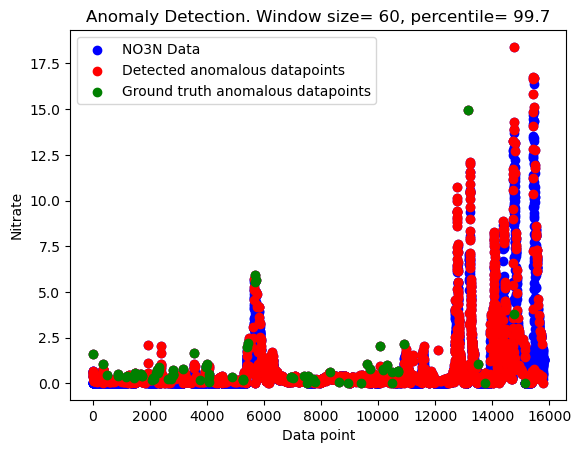

Normal flags: 13990
Anomaly flags: 1818
True Positives: 64
True Negatives: 13977
False Positives: 1754
False Negatives: 13
Precision: 0.0352035203520352
Recall: 0.8311688311688312
Accuracy as (TP + TN) / (TP + TN + FP + FN): 0.8882211538461539
accuracy_anomaly_detection as TP / anomaliesGT: 0.8311688311688312
accuracy_normal_detection as TN / (len(df_anomaly1) - anomaliesGT): 0.8885004131968725


In [5]:
df1 = df.copy()

best_percentileUpper = results.loc[maxPerformance]['percentileUpper']
best_percentileLower = 100 - percentileUpper
#print(best_percentileUpper)

best_window_size = results.loc[maxPerformance]['window_size']
#print(best_window_size)

df_best_anomaly, count_0, count_1 = evaluation(df1, best_window_size, step_size, anomaliesGT, best_percentileUpper, best_percentileLower)
    
best_anomalies = df_best_anomaly[df_best_anomaly['label'] == '1']
    
plt.scatter(df1.index, df1['NO3N'], color='blue', label='NO3N Data')
plt.scatter(df_best_anomaly[df_best_anomaly['label'] == 1].index, df_best_anomaly[df_best_anomaly['label'] == 1]['NO3N'], color='red', label='Detected anomalous datapoints')
plt.scatter(df_best_anomaly[df_best_anomaly['Student_Flag'] == 1].index, df_best_anomaly[df_best_anomaly['Student_Flag'] == 1]['NO3N'], color='green', label='Ground truth anomalous datapoints')
plt.xlabel('Data point')
plt.ylabel('Nitrate')
plt.title(f'Anomaly Detection. Window size= {best_window_size}, percentile= {best_percentileUpper}')
plt.legend(loc='upper left')
plt.show()
        
performanceFull(df_best_anomaly, anomaliesGT)